In [2]:
# Визуализировать распределение времени жизни авторов в зависимости от страны
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def dt_parse(x):  # standard parser does not work due to its ranges
    if x == "nan":
        return "nan"
    year, month, day = x.split('-')
    return pd.Period(
        year=int(year),
        month=int(month),
        day=int(day),
        freq='D')

dataframe = pd.read_table(
    'data.tsv',
    parse_dates=['birth_date', 'death_date'],
    date_parser=dt_parse)

dataframe['lifespan'] = dataframe.apply(
    lambda x: 0 if x.death_date == "nan" or x.birth_date == "nan"
        else (x.death_date - x.birth_date) / 365, axis=1)

def get_country(df):
    return df.death_place.split(',')[-1] if type(df.death_place) is str else \
        df.birth_place.split(',')[-1] if type(df.birth_place) is str else ''

dataframe['country'] = dataframe.apply(get_country, axis=1)

grouped = dataframe[['lifespan', 'num_books', 'adepts', 'country']].groupby('country', as_index=False).mean()

countries = pd.read_csv('GeoLite2-Country-Locations-ru.csv')

merged = grouped.merge(countries, left_on='country', right_on='country_name')
grouped_lifespan = merged[merged.lifespan != 0].groupby('country', as_index=False)
data = grouped_lifespan.mean().sort_values('lifespan', ascending=False)

lifespan_list = data['lifespan'].tolist()
countries_list = data['country'].tolist()

plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(20,20)

y_pos = np.arange(len(data['lifespan']))

bar_width = 0.35
opacity = 0.4

ax.barh(y_pos, lifespan_list, bar_width,
                alpha=opacity, color='b',
                label='Lifespan')
ax.set_yticks(y_pos)
ax.set_xlabel('Lifespan')
ax.set_ylabel('Countries')
ax.set_title('Lifespan by countries')
ax.invert_yaxis()
ax.set_yticklabels(countries_list)
ax.legend()

fig.tight_layout()
plt.show()

<Figure size 2000x2000 with 1 Axes>

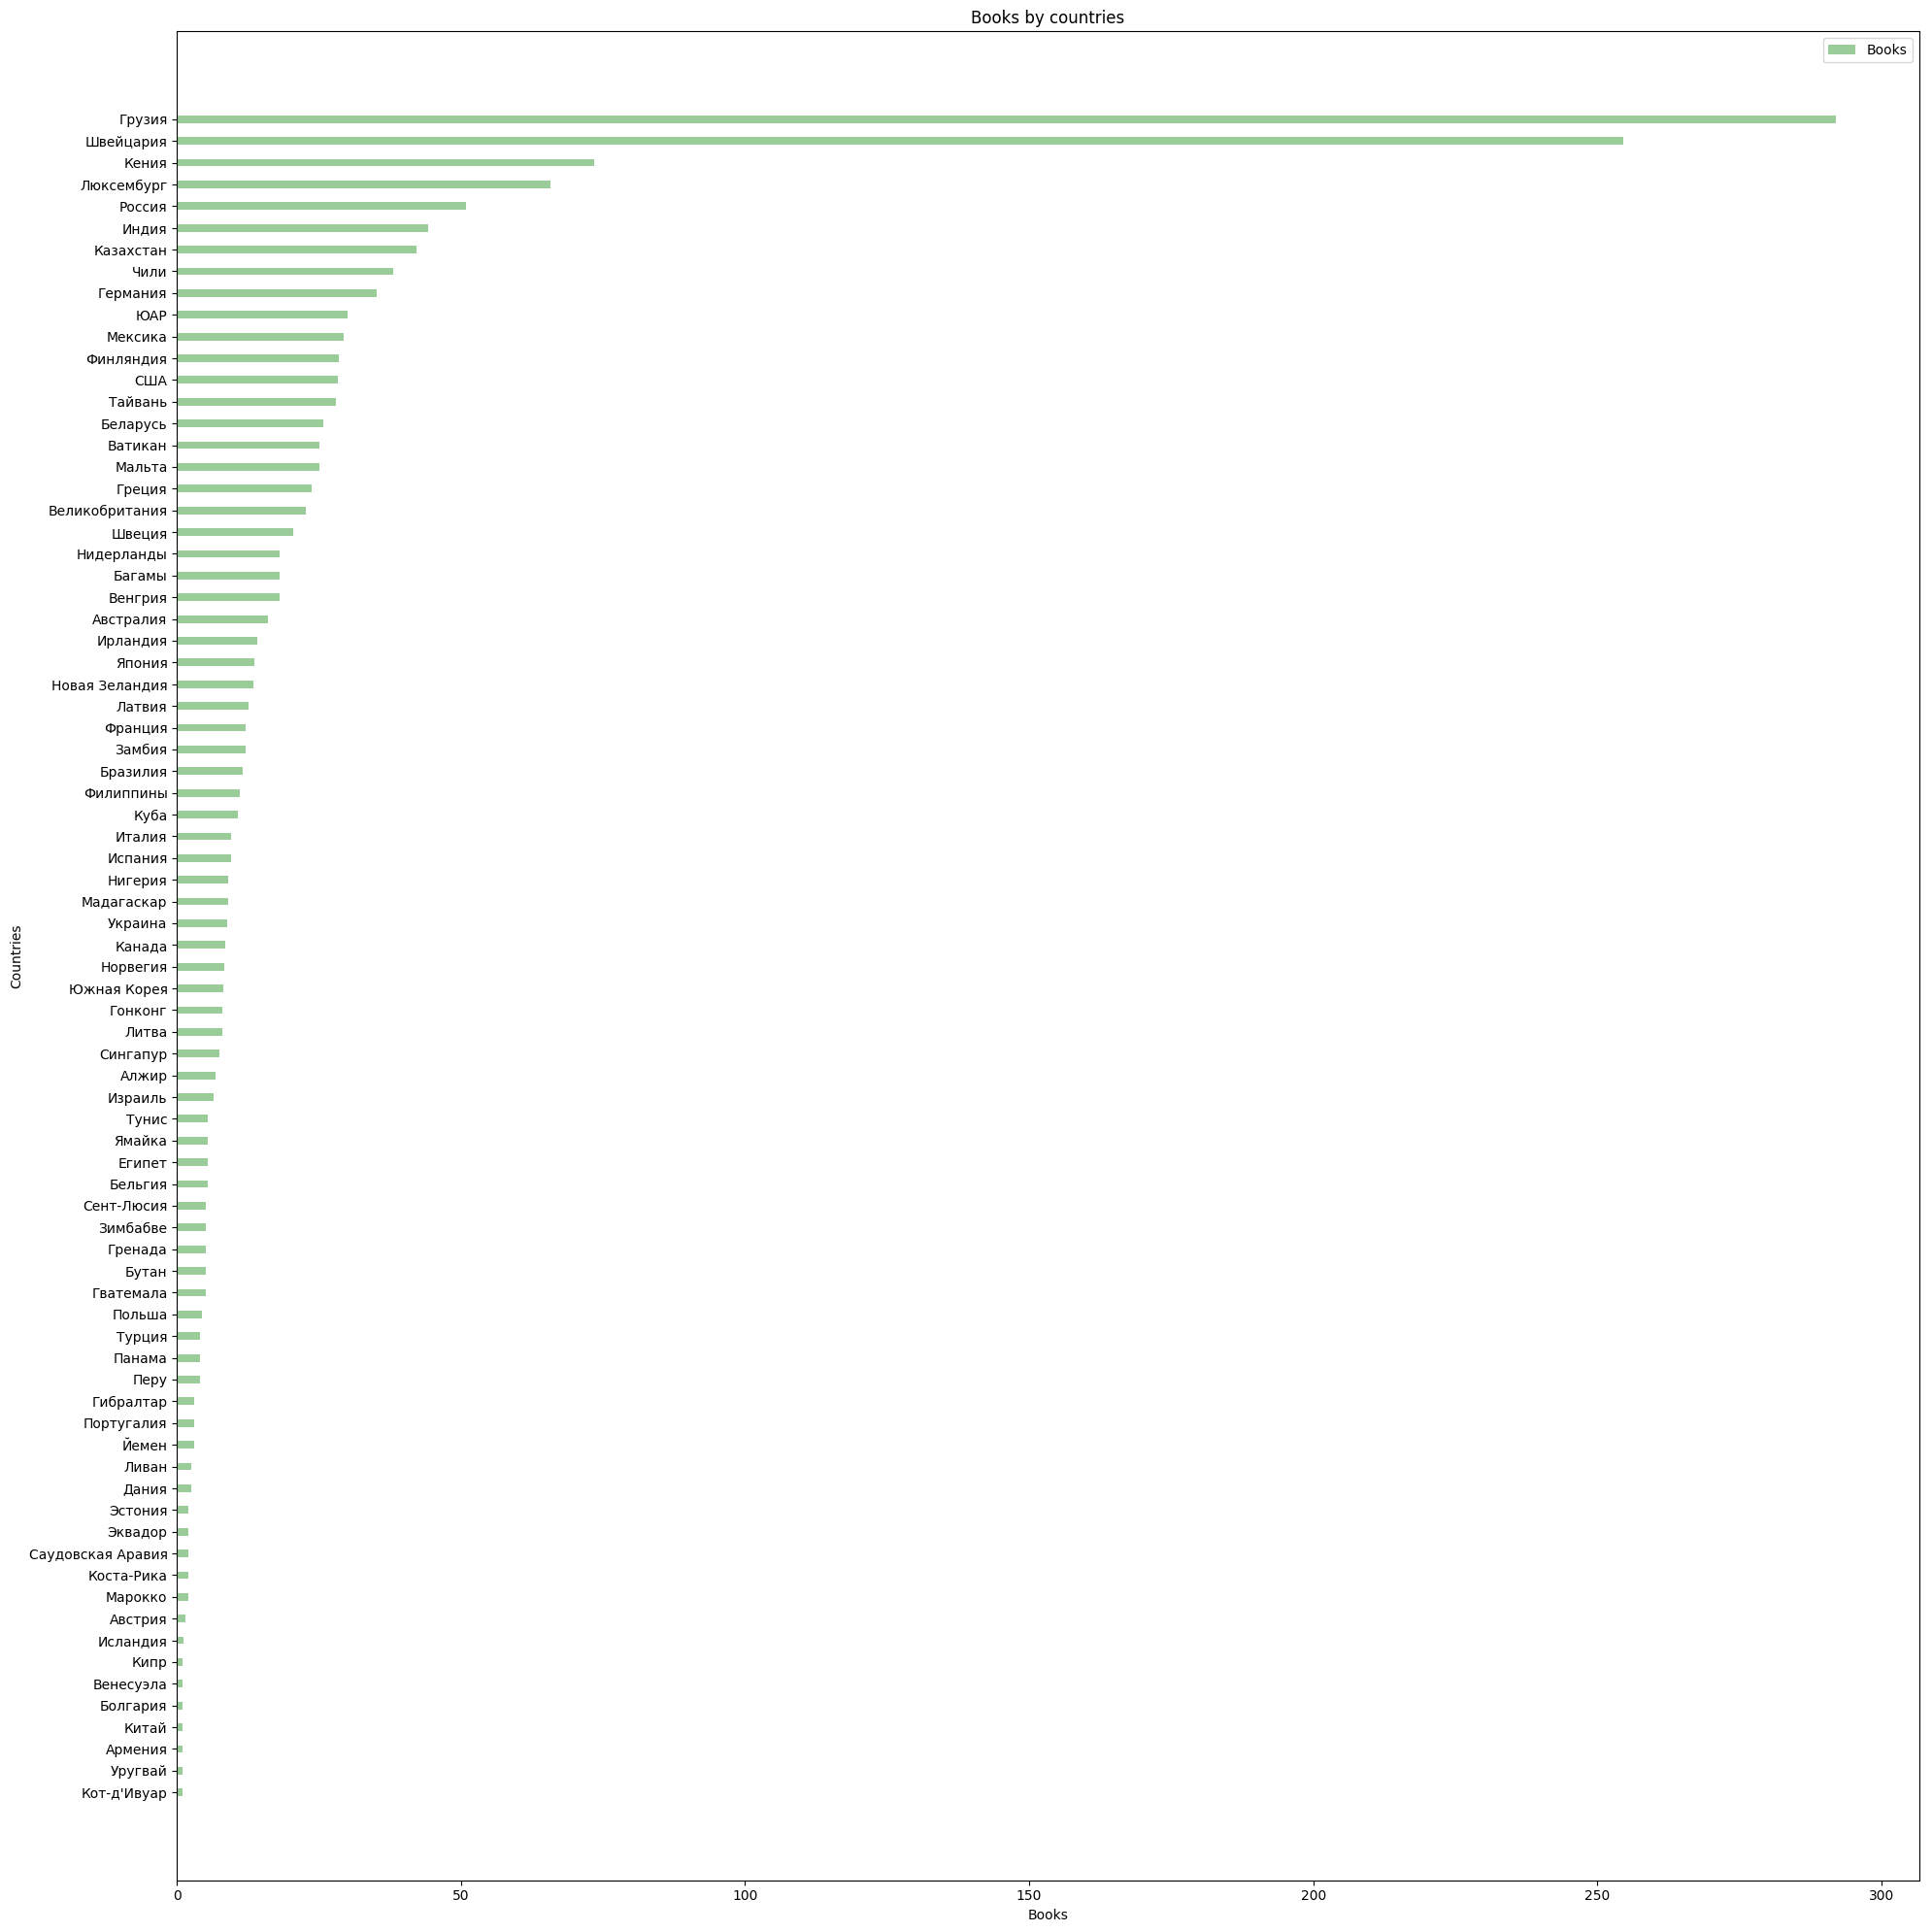

In [3]:
# Среднее количество книг авторов в зависимости от страны
grouped_books = merged[merged.num_books != 0].groupby('country', as_index=False)
data = grouped_books.mean().sort_values('num_books', ascending=False)

num_books_list = data['num_books'].tolist()
countries_list = data['country'].tolist()

plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(20,20)

y_pos = np.arange(len(data['num_books']))

ax.barh(y_pos, num_books_list, bar_width,
                alpha=opacity, color='g',
                label='Books')
ax.set_yticks(y_pos)
ax.set_xlabel('Books')
ax.set_ylabel('Countries')
ax.set_title('Books by countries')
ax.invert_yaxis()
ax.set_yticklabels(countries_list)
ax.legend()

fig.tight_layout()
plt.show()


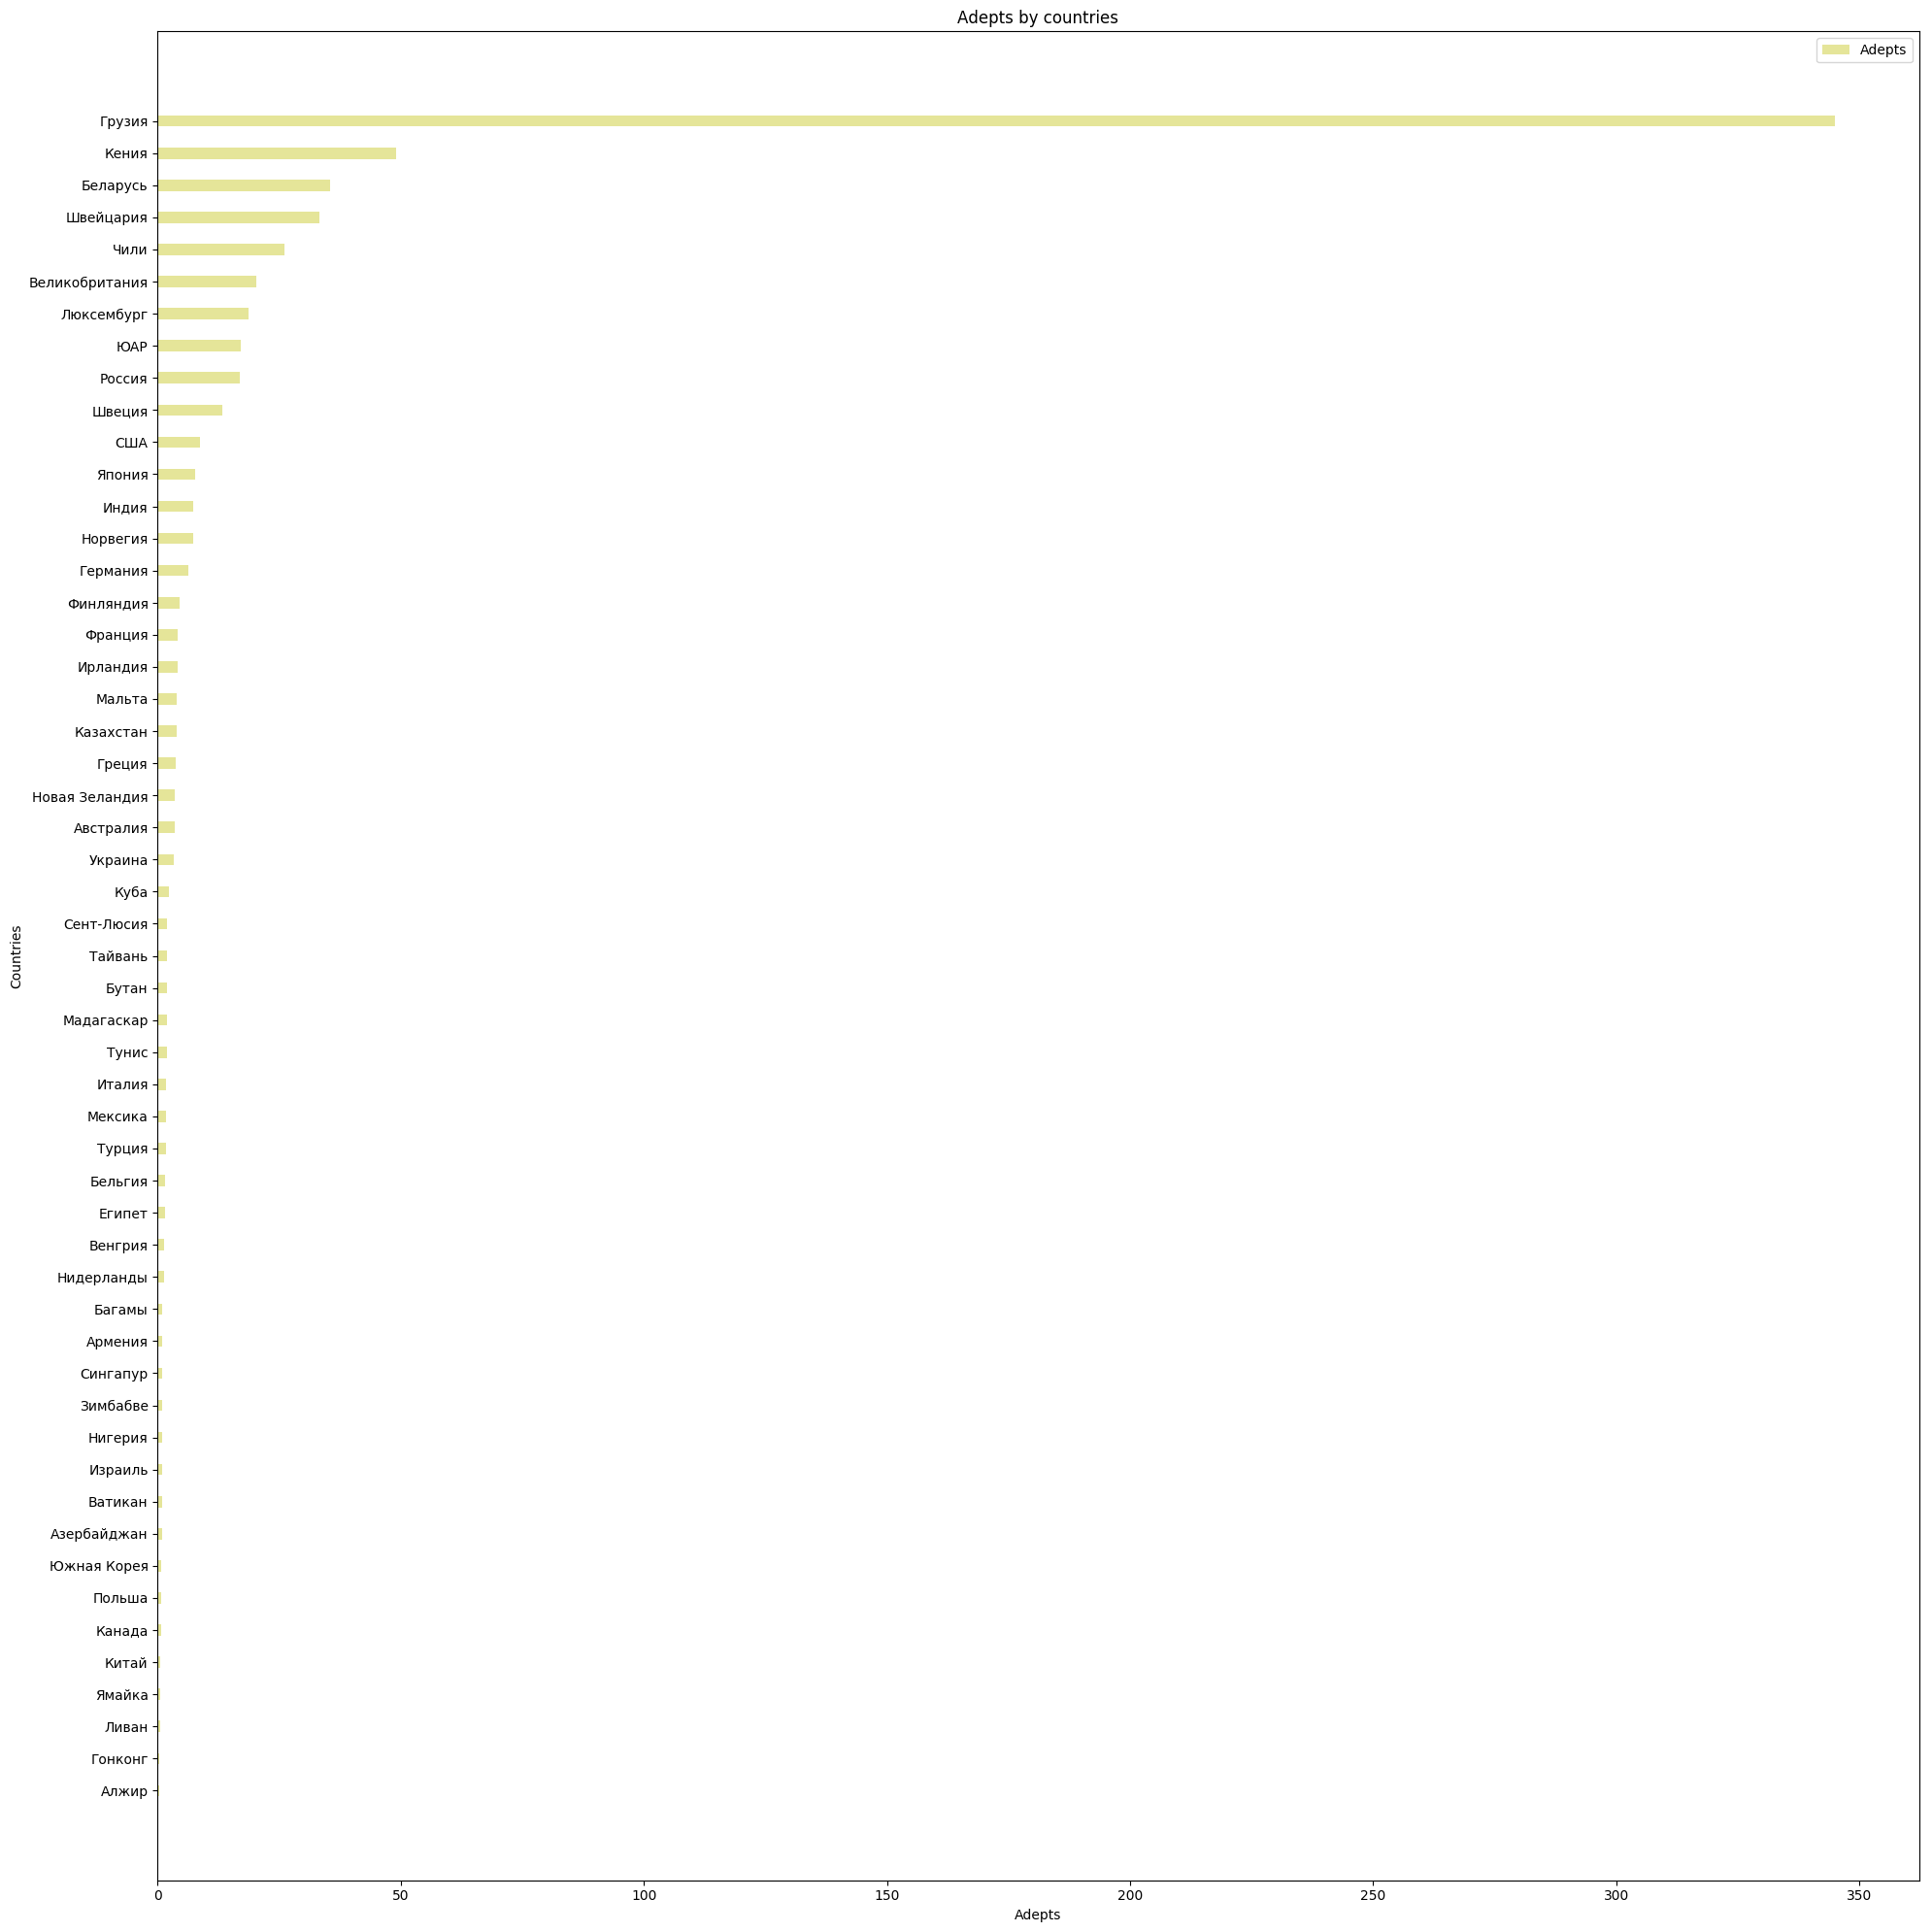

In [4]:
# Среднее количество почитателей в зависимости от страны
grouped_adepts = merged[merged.adepts != 0].groupby('country', as_index=False)
data = grouped_adepts.mean().sort_values('adepts', ascending=False)

adepts_list = data['adepts'].tolist()
countries_list = data['country'].tolist()

plt.rcdefaults()
fig, ax = plt.subplots()
fig.set_size_inches(20,20)

y_pos = np.arange(len(data['adepts']))

ax.barh(y_pos, adepts_list, bar_width,
                alpha=opacity, color='y',
                label='Adepts')
ax.set_yticks(y_pos)
ax.set_xlabel('Adepts')
ax.set_ylabel('Countries')
ax.set_title('Adepts by countries')
ax.invert_yaxis()
ax.set_yticklabels(countries_list)
ax.legend()

fig.tight_layout()
plt.show()

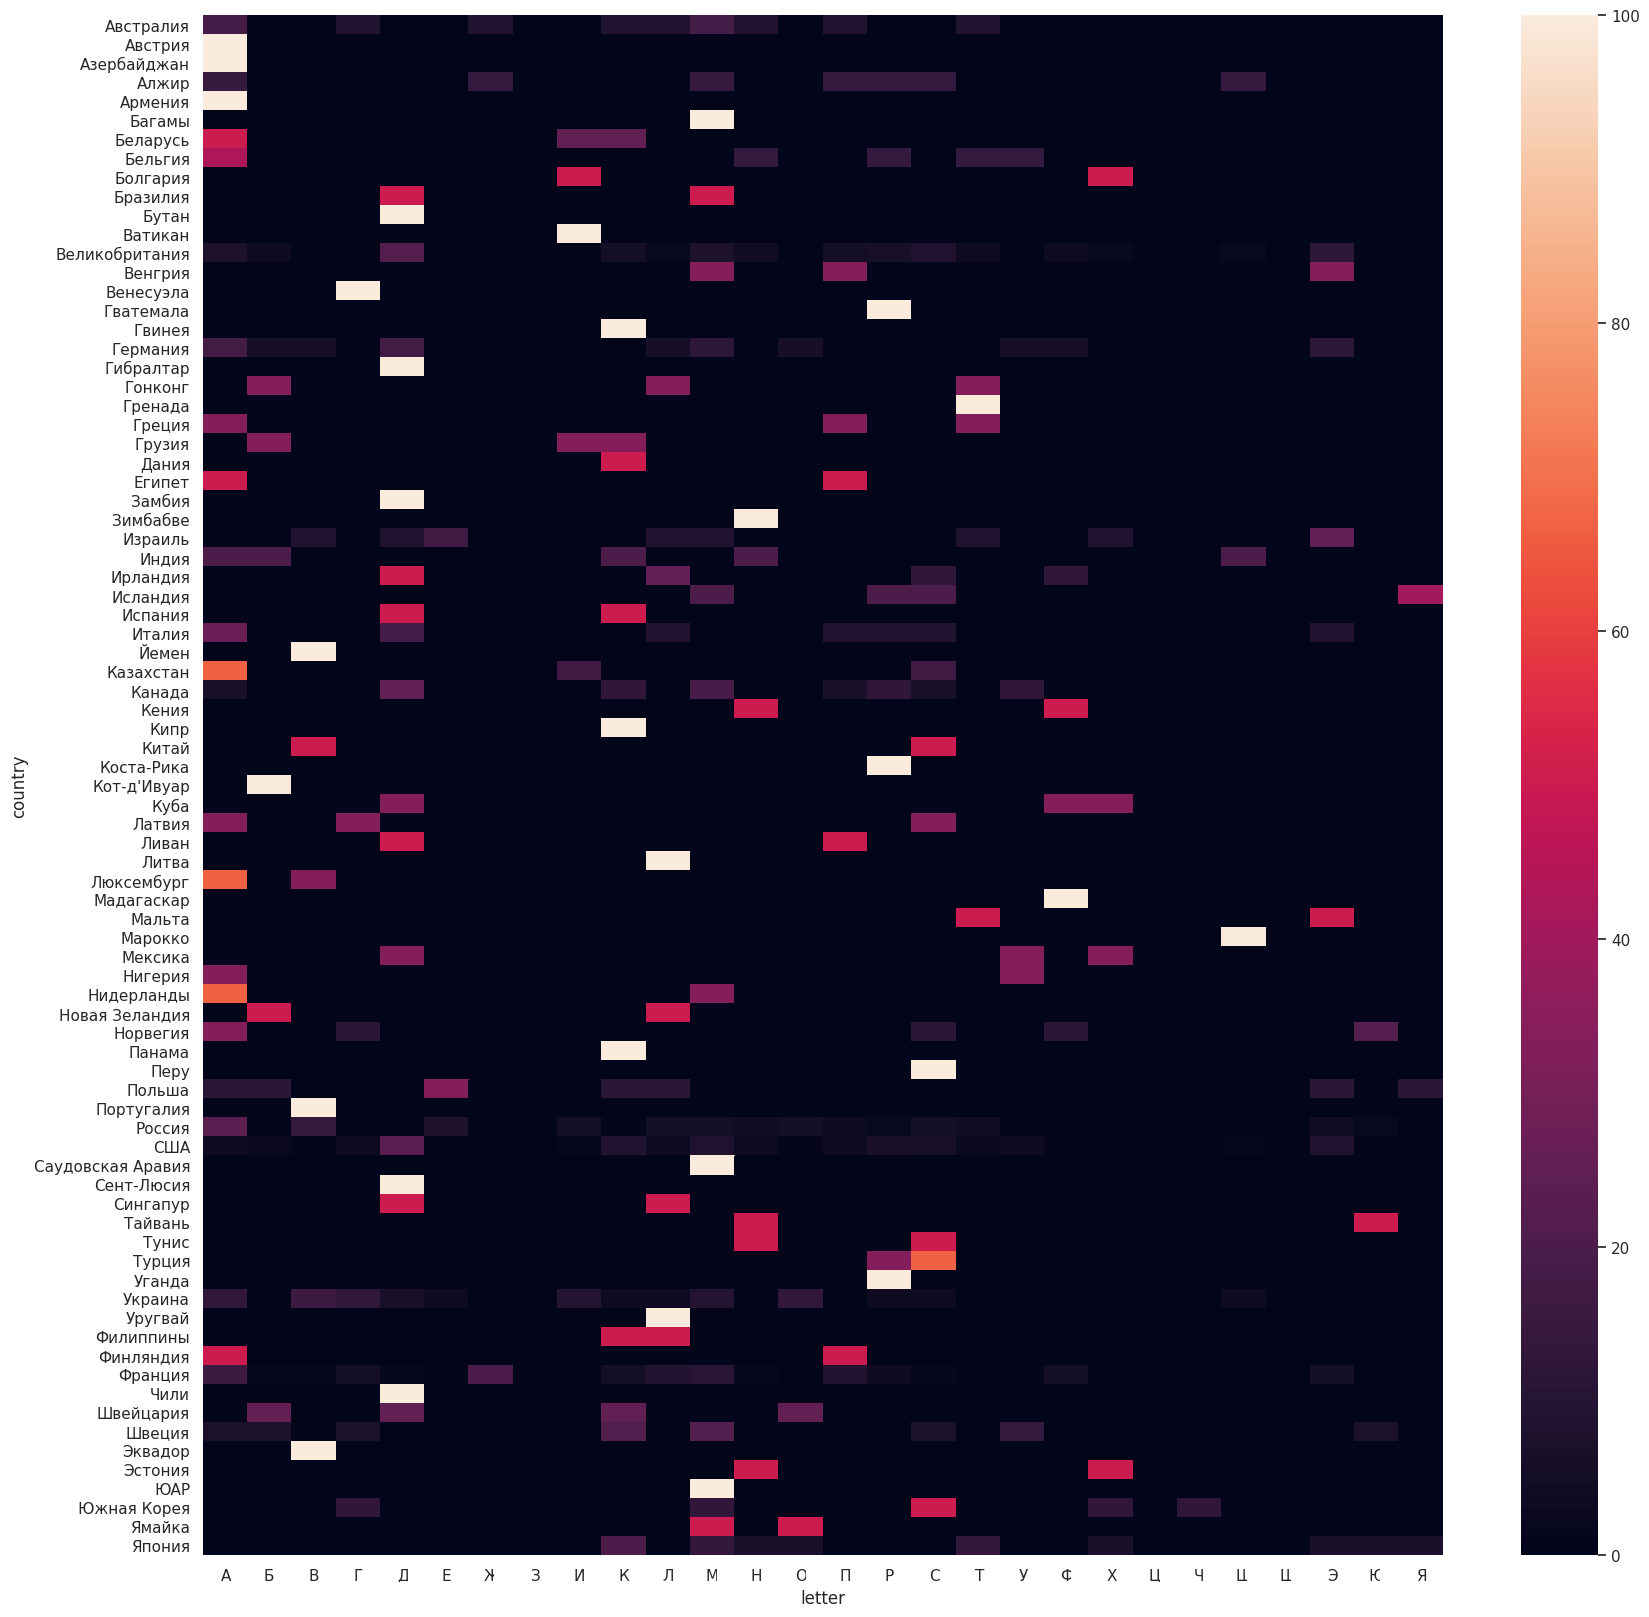

In [5]:
# Распределение первой буквы имени в зависимости от страны
import seaborn as sns; sns.set()
from collections import defaultdict

uppercase = 'АБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЭЮЯ'

grouped = dataframe[['name', 'lifespan', 'num_books', 'adepts', 'country']].groupby(['country', 'name'], as_index=False).mean()
merged = grouped.merge(countries, left_on='country', right_on='country_name')

names = merged[['name', 'country']].groupby('country')

df = pd.DataFrame({'country': [], 'letter': [], 'frequency_first': [], 'frequency_last': []})

counts = {}
count = {}
for groupName, groupLabel in names.groups.items():
    group = names.get_group(groupName)

    countryGroup = group['country']
    countryName = countryGroup.iloc[0]
    count[countryName] = group.shape[0]

    counts[countryName] = {'countFirst': defaultdict(int), 'countLast': defaultdict(int)}
    for letter in uppercase:
        counts[countryName]['countFirst'][letter] += group[group.name.str.startswith(letter)].count()['name']
        counts[countryName]['countLast'][letter] += group[group.name.str.endswith(str.lower(letter))].count()['name']

    
for country, counters in counts.items():
    for letter in uppercase:
        df = df.append(pd.DataFrame({
            'country': [country],
            'letter': [letter],
            'frequency_first': [counters['countFirst'][letter] / count[country] * 100 if letter in counters['countFirst'] else 0],
            'frequency_last': [counters['countLast'][letter] / count[country] * 100 if letter in counters['countLast'] else 0]}))

df1 = df.pivot("country", "letter", "frequency_first")

fig, ax = plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(df1, ax=ax)


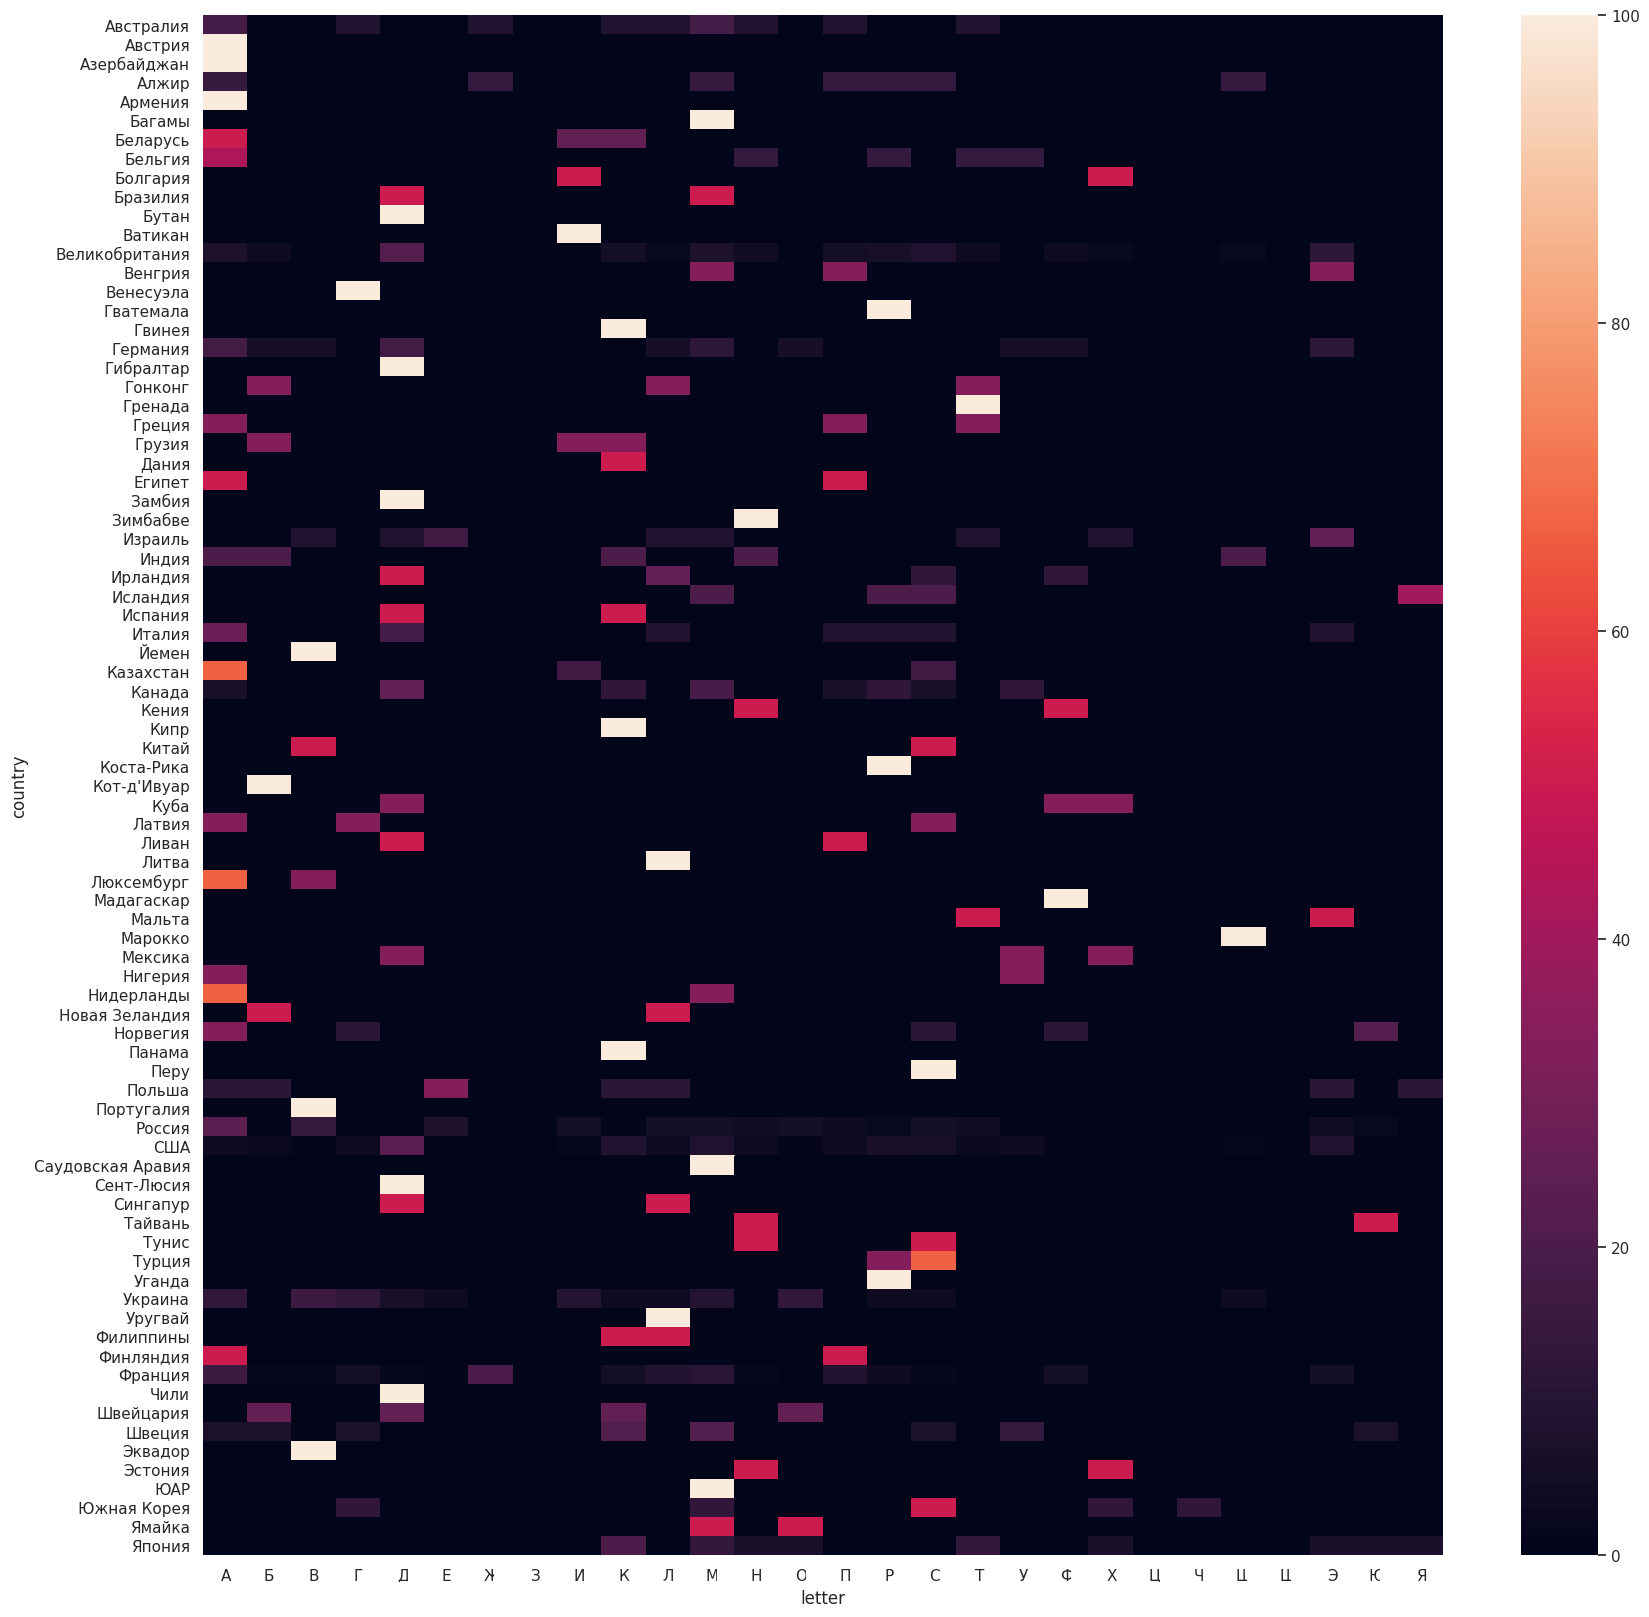

In [6]:
# Распределение последней буквы имени в зависимости от страны
df2 = df.pivot("letter", "country", "frequency_last")
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(df1, ax=ax)

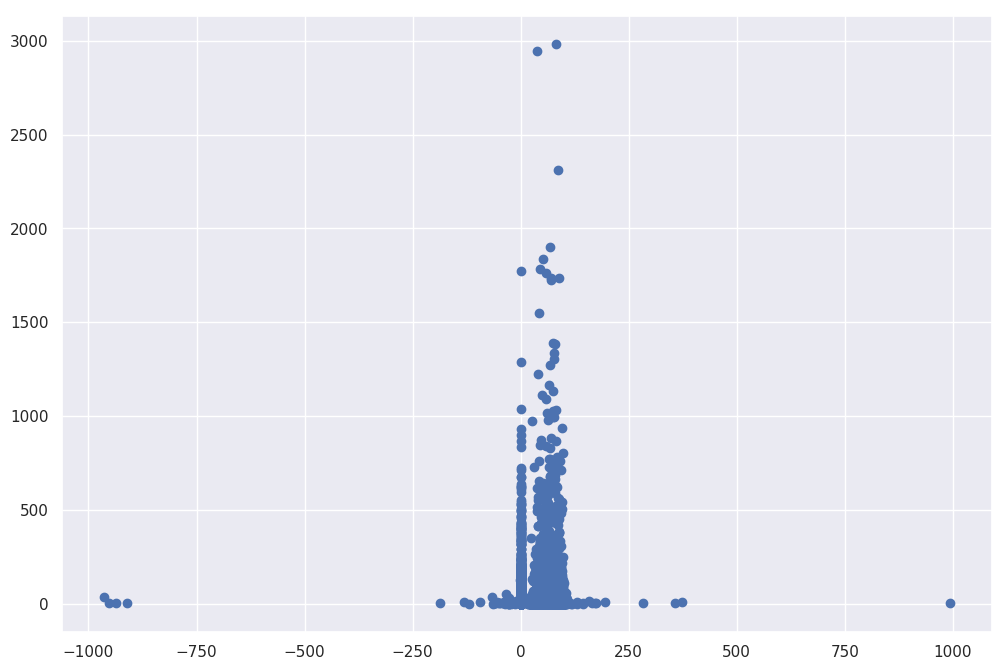

In [7]:
# Есть ли зависимость между возрастом и количеством произведений
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))
ax1.plot(dataframe['lifespan'], dataframe['num_books'], 'o')

In [ ]:
# Есть ли корреляция между именем и продолжительностью жизни
fig, ax1 = plt.subplots(1, 1, figsize=(12,8))

lifespan = dataframe[dataframe.lifespan != 0]
#df1['e'] = Series(np.random.randn(sLength), index=df1.index)
lifespan['first_name'] = lifespan.name.str.extract('([^\ ]+[\ ]*)',expand=False)
names = lifespan[['first_name', 'lifespan']]#.groupby('first_name').mean()

#names = names.xs('lifespan', axis=1)

#print(names)
#names.columns = names.columns.droplevel()

names_list = names.first_name.tolist()
lifespan_list = names.lifespan.tolist()
print(names_list)
plt.rcdefaults()

fig.set_size_inches(20,20)

y_pos = np.arange(len(names['lifespan']))

ax1.barh(y_pos, lifespan_list, bar_width,
                alpha=opacity, color='y',
                label='Lifespan')
ax1.set_yticks(y_pos)
ax1.set_xlabel('Lifespan')
ax1.set_ylabel('Names')
ax1.set_title('Lifespan by names')
ax1.invert_yaxis()
ax1.set_yticklabels(names_list)
ax1.legend()

fig.tight_layout()
plt.show()
#names.set_index('name')
#ax1.plot(names['lifespan'], names['name'], 'o')